# Data Analysis
## Read the raw data from .csv files

In [1]:
import pandas as pd
import os as os

# Get subject list from file names
data_dir='data/tracking/'
files = os.listdir(data_dir)
subjects = [ f.split('g.csv')[0] for f in files if 'g.csv' in f ]

# Load the score data by subject
# Read votes from csv-files to Pandas DataFrames and concatenate
def read_votes(x):
    df = pd.read_csv(data_dir + x + 'g.csv')
    df.columns =['Stimulus','Vote','TrackID']
    df['Subject'] = x
    return df
df = pd.concat([ read_votes(s) for s in subjects ]).reset_index(drop=True)

# Rename stimuli
def rn_st(s):
    d = {'C3':'C1', 'C8':'C2', 'C10':'C3', 'C11':'C4', 'C12':'C5'}
    return d[s]
# Rename method
def rn_md(s):
    d = {'CSH':'CSH', 'CSH360':'CSH360',
         'Criminisi':'Criminisi','Criminisi360':'Criminisi360',
         'FFIIwGC':'GIIwCA', 'FFIIwGC360':'GIIwCA360'}
    return d[s]

# Parce stimulus names to Image and Method
name_parsed = pd.DataFrame(
    [ [rn_st(s.split('_')[1]),rn_md(s.split('_')[4])] for s in df['Stimulus'] ],
    columns=['Image','Method']
)
df = df.merge(name_parsed,left_index=True, right_index=True)

dfExpData = df[['Subject','Stimulus','Image','Method','Vote']]

dfExpData.to_csv('experiment_data.csv')

print("Number of subjects:",len(subjects))
dfExpData.head()

Number of subjects: 16


,Subject,Stimulus,Image,Method,Vote
0,1540200586223,various_C11_equirec_2048x1024_Criminisi_q00.jpg,C4,Criminisi,2
1,1540200586223,various_C3_equirec_2048x1024_CSH360_q00.jpg,C1,CSH360,3
2,1540200586223,various_C12_equirec_2048x1024_Criminisi_q00.jpg,C5,Criminisi,2
3,1540200586223,various_C8_equirec_2048x1024_Criminisi_q00.jpg,C2,Criminisi,4
4,1540200586223,various_C10_equirec_2048x1024_Criminisi360_q00...,C3,Criminisi360,4


## Perform outlier detection
Outliers detections method is described in
ITU-R BT.500-13 (2012): Section 2.3.1, Page 35

In [2]:
import numpy as np
import scipy.stats as ss
from functools import reduce

# Outlier detection

df = dfExpData # Get a copy of the data

# Calculate moments: mean, standard deviation, kurtosis per stimulus
ms = pd.DataFrame([(stimulus, votes.mean(), votes.std(),votes.kurtosis()) 
                   for stimulus, votes in df.groupby('Stimulus')['Vote']
                  ],
                  columns = ['Stimulus','Mean','Std','Kurt'])

pqs = list() # List if P[i] and Q[i]
for sub in subjects: # Iterate over subjects
    p,q = 0,0
    for _,m in ms.iterrows(): # Iterate over subject's votes
        v = int( df[(df.Subject == sub)&(df.Stimulus == m.Stimulus)]['Vote'] )
        stdcoeff = np.sqrt(20) if m.Kurt < 2 or m.Kurt > 4 else 2 # Consider normal distribution if Kurt is in [2..4]
        if v > m.Mean + m.Std*stdcoeff :  # If the vote is higher then interval
            p = p + 1                     # increment P
        if v < m.Mean - m.Std*stdcoeff :  # If the vote is lower then interval
            q = q + 1                     # increment Q
        #print(sub,m.Stimulus,np.round(m.Kurt,1),v,np.round(m.Mean-m.Std*stdcoeff,1),np.round(m.Mean+m.Std*stdcoeff,1),p,q)
    pqs.append((sub, p, q))
pqs = pd.DataFrame(pqs, columns=['Subject','P','Q'])

N = len(set(df['Stimulus'])) # Number of stimuli (aka number of votes per subject)

# If the number of outlying votes for a subject is > 5%
# and the difference between number of votes lying upper (P) and lower (Q)
# the specified interval is < 30% (i.e. outlying votes are rather balanced)
# consider the subject as an outlier
pqs['isOutlier'] = [(((s.P+s.Q)/N) > 0.05) and (abs((s.P-s.Q)/(s.P+s.Q)) < 0.3) for _,s in pqs.iterrows()]

outliers = list(pqs[pqs.isOutlier]['Subject'])

print('Outliers detected:',len(outliers))
print(outliers)

# Remove outliers
if len(outliers):
    dfExpDataScreened = df[ [reduce((lambda x,y: x and y),z) for z in zip(*[df.Subject!=o for o in outliers])] ]
else:
    dfExpDataScreened = df
dfExpDataScreened.to_csv('experiment_data_screened.csv')

Outliers detected: 0
[]


## Plot mean opinion scores (MOS) with 95% confidence intervals (CI)

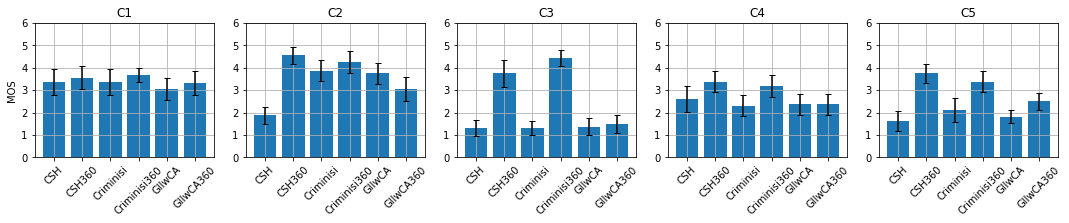

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss

# Get a copy of the screened data
df = dfExpDataScreened

images = list(set(df.Image)); images.sort()

# Calculate 95% confidence interval assuming Student's T distribution
def get_ci(xs):
    return ss.t.interval(0.95, len(xs)-1, loc=np.mean(xs),
                         scale=ss.sem(xs)) if ss.sem(xs) > 0 else (np.mean(xs),np.mean(xs))

# Draw a MOS (sub)plot 
def plot_mos_per_image(im):
    # Retrive data for an image 'im' and group by method
    xs = list(df[df['Image'] == im][['Method','Vote']].groupby(['Method']))
    methods = [x[0] for x in xs]
    # Calculate means for stimulus data grouped earlier
    means = [np.mean(x[1]['Vote']) for x in xs]
    errors = [np.abs(np.array(get_ci(x[1]['Vote']))-np.mean(x[1]['Vote'])) for x in xs]
    errors = list(zip(*errors)) # Re-format the list to feed to matplotlib.errorbar
    x = list(range(0,len(methods))) 
    plt.xticks(x, methods,rotation='45') # X-axis tick labels
    plt.bar(x, means, yerr=errors, capsize=3)
    

# Perform drawing of the plots for MOS with CI
i = 1; k = 5
plt.subplots(i,k,figsize=(15,3.2*i))
plt.axis('off')
for n,im in enumerate(images):
    plt.subplot(i, k, n+1)
    plot_mos_per_image(im)
    plt.grid(); plt.title(im)
    plt.ylim((0,6));
    if n%k==0 : plt.ylabel('MOS')

plt.tight_layout()
plt.savefig("Mos.pdf")

plt.show()